Goal proyek kita kali ini adalah menghasilkan rekomendasi sejumlah restoran yang sesuai dengan preferensi pengguna berdasarkan rating yang telah diberikan sebelumnya. Dari data rating pengguna, kita akan mengidentifikasi restoran-restoran yang mirip dan belum pernah dikunjungi oleh pengguna untuk direkomendasikan. Kita akan menggunakan teknik collaborative filtering untuk membuat rekomendasi ini. 

# Data Understanding

In [ ]:
# Import library
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/RCdata.zip

Archive:  /content/RCdata.zip
replace chefmozaccepts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace chefmozaccepts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: chefmozaccepts.csv      
  inflating: chefmozcuisine.csv      
  inflating: chefmozhours4.csv       
  inflating: chefmozparking.csv      
  inflating: geoplaces2.csv          
  inflating: rating_final.csv        
  inflating: README                  
  inflating: usercuisine.csv         
  inflating: userpayment.csv         
  inflating: userprofile.csv         


In [ ]:
import pandas as pd
 
accepts = pd.read_csv('/content/chefmozaccepts.csv')
cuisine = pd.read_csv('/content/chefmozcuisine.csv')
hours = pd.read_csv('/content/chefmozhours4.csv')
parking = pd.read_csv('/content/chefmozparking.csv')
geo = pd.read_csv('/content/geoplaces2.csv', encoding = "ISO-8859-1")
usercuisine = pd.read_csv('/content/usercuisine.csv')
payment = pd.read_csv('/content/userpayment.csv')
profile = pd.read_csv('/content/userprofile.csv')
rating = pd.read_csv('/content/rating_final.csv')
 
print('Jumlah data pembayaran yang diterima restoran: ', len(accepts.placeID.unique()))
print('Jumlah data masakan pada restoran: ', len(cuisine.placeID.unique()))
print('Jumlah data waktu buka restoran: ', len(hours.placeID.unique()))
print('Jumlah data lokasi restoran: ', len(geo.placeID.unique()))
print('Jumlah data masakan pengguna: ', len(usercuisine.userID.unique()))
print('Jumlah data profil pengguna: ', len(profile.userID.unique()))
print('Jumlah data penilaian yang diberikan pengguna: ', len(rating.userID.unique()))
print('Jumlah data penilaian restoran: ', len(rating.placeID.unique()))

Jumlah data pembayaran yang diterima restoran:  615
Jumlah data masakan pada restoran:  769
Jumlah data waktu buka restoran:  694
Jumlah data lokasi restoran:  130
Jumlah data masakan pengguna:  138
Jumlah data profil pengguna:  138
Jumlah data penilaian yang diberikan pengguna:  138
Jumlah data penilaian restoran:  130


In [ ]:
df = pd.read_csv('/content/rating_final.csv')
df

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


# Data Preprocessing

## Menggabungkan seluruh kategori restoran

Kita akan menggabungkan seluruh data pada kategori Restaurant. Sehingga, kita akan menggunakan placeID yang unik sebagai acuan dalam penggabungan ini. Implementasikan kode berikut.

In [ ]:
import numpy as np
 
# Menggabungkan seluruh placeID pada kategori Restaurant
resto_all = np.concatenate((
    accepts.placeID.unique(),
    cuisine.placeID.unique(),
    hours.placeID.unique(),
    parking.placeID.unique(),
    geo.placeID.unique()
))

# Mengurutkan data dan menghapus data yang sama
resto_all = np.sort(np.unique(resto_all))

print('Jumlah seluruh data restoran berdasarkan placeID: ', len(resto_all))

Jumlah seluruh data restoran berdasarkan placeID:  938


Perhatikanlah, setelah file pada kategori Restaurant digabung, kita memiliki 938 restoran yang unik.

## Menggabungkan seluruh kategori user

Kita akan menggabungkan seluruh data pada kategori User. Sehingga, kita akan menggunakan userID yang unik sebagai acuan dalam penggabungan ini.
Implementasikan kode berikut.

In [ ]:
# Menggabungkan seluruh userID
user_all = np.concatenate((
    usercuisine.userID.unique(),
    payment.userID.unique(),
    profile.userID.unique()
))
 
# Menghapus data yang sama kemudian mengurutkannya
user_all = np.sort(np.unique(user_all)) 
 
print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  138


Perhatikanlah, setelah file pada kategori User digabung, kita memiliki 138 user yang unik dari 938 restoran yang memiliki rating.

## Mengetahui Jumlah Rating

In [ ]:
# Menggabungkan file accepts, geo, parking, hours ke dalam dataframe resto_info 
resto_info = pd.concat([accepts, geo, parking, hours])
 
# Menggabungkan dataframe rating dengan resto_info berdasarkan nilai placeID
resto = pd.merge(rating, resto_info , on='placeID', how='left')
resto

,userID,placeID,rating,food_rating,service_rating,Rpayment,latitude,longitude,the_geom_meter,name,...,accessibility,price,url,Rambience,franchise,area,other_services,parking_lot,hours,days
0,U1077,135085,2,2,2,cash,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U1077,135085,2,2,2,NaN,22.150802,-100.982680,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,...,no_accessibility,medium,?,familiar,f,closed,none,NaN,NaN,NaN
2,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,public,NaN,NaN
3,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;
4,U1077,135085,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-00:00;,Sat;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,U1068,132660,0,0,0,NaN,23.752943,-99.164679,0101000020957F00003D7905C9DC8157C13FCD1AB7334E...,carnitas mata calle Emilio Portes Gil,...,completely,low,?,familiar,f,closed,none,NaN,NaN,NaN
8074,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN
8075,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Mon;Tue;Wed;Thu;Fri;
8076,U1068,132660,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00:00-23:30;,Sat;


In [ ]:
# Cek missing value dengan fungsi isnull()
resto.isnull().sum()

userID               0
placeID              0
rating               0
food_rating          0
service_rating       0
Rpayment          5781
latitude          6917
longitude         6917
the_geom_meter    6917
name              6917
address           6917
city              6917
state             6917
country           6917
fax               6917
zip               6917
alcohol           6917
smoking_area      6917
dress_code        6917
accessibility     6917
price             6917
url               6917
Rambience         6917
franchise         6917
area              6917
other_services    6917
parking_lot       6917
hours             4619
days              4619
dtype: int64

In [ ]:
# Menghitung jumlah rating, food_rating, dan service kemudian menggabungkannya berdasarkan placeID
resto.groupby('placeID').sum()

,rating,food_rating,service_rating,latitude,longitude
placeID,,,,,
132560,12,24,6,95.009216,-396.667653
132561,15,20,20,94.907276,-396.506024
132564,25,25,30,94.923698,-396.580739
132572,90,90,84,332.124707,-1514.890677
132583,24,24,30,75.689162,-396.937328
...,...,...,...,...,...
135088,36,42,36,113.256068,-595.319338
135104,48,80,48,166.270875,-694.179039
135106,96,96,96,221.497088,-1009.760928


## Menggabungkan Data dengan Fitur Nama Resto

In [ ]:
# Definisikan dataframe rating ke dalam variabel all_resto_rate
all_resto_rate = rating
all_resto_rate

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2
...,...,...,...,...,...
1156,U1043,132630,1,1,1
1157,U1011,132715,1,1,0
1158,U1068,132733,1,1,0
1159,U1068,132594,1,1,1


In [ ]:
# Menggabungkan all resto_rate dengan dataframe geo berdasarkan placeID
all_resto_name = pd.merge(all_resto_rate, geo[['placeID','name']], on='placeID', how='left')
 
# Print dataframe all_resto_name
all_resto_name

,userID,placeID,rating,food_rating,service_rating,name
0,U1077,135085,2,2,2,Tortas Locas Hipocampo
1,U1077,135038,2,2,1,Restaurant la Chalita
2,U1077,132825,2,2,2,puesto de tacos
3,U1077,135060,1,2,2,Restaurante Marisco Sam
4,U1068,135104,1,1,2,vips
...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,palomo tec
1157,U1011,132715,1,1,0,tacos de la estacion
1158,U1068,132733,1,1,0,Little Cesarz
1159,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec


In [ ]:
all_resto_name.isnull().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
name              0
dtype: int64

## Menggabungkan Data dengan Fitur masakan Resto

In [ ]:
# Menggabungkan dataframe cuisine dengan all_resto_name dan memasukkannya ke dalam variabel all_resto 
all_resto = pd.merge(all_resto_name, cuisine, on='placeID', how='left')
all_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
1,U1077,135038,2,2,1,Restaurant la Chalita,NaN
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
...,...,...,...,...,...,...,...
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican


Inilah data yang akan kita gunakan untuk membuat sistem rekomendasi. Berikutnya, mari kita menuju tahapan Data Preparation.

# Data Preparation

In [ ]:
all_resto.isnull().sum()

userID              0
placeID             0
rating              0
food_rating         0
service_rating      0
name                0
Rcuisine          288
dtype: int64

In [ ]:
# Membersihkan missing value dengan fungsi dropna()
all_resto_clean = all_resto.dropna()
all_resto_clean

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
0,U1077,135085,2,2,2,Tortas Locas Hipocampo,Fast_Food
2,U1077,132825,2,2,2,puesto de tacos,Mexican
3,U1077,135060,1,2,2,Restaurante Marisco Sam,Seafood
4,U1068,135104,1,1,2,vips,Mexican
5,U1068,132740,0,0,0,Carreton de Flautas y Migadas,Mexican
...,...,...,...,...,...,...,...
1325,U1043,132732,1,1,1,Taqueria EL amigo,Mexican
1326,U1043,132630,1,1,1,palomo tec,Mexican
1327,U1011,132715,1,1,0,tacos de la estacion,Mexican
1328,U1068,132733,1,1,0,Little Cesarz,Pizzeria


## Mengurutkan berdasarkan jenis makanan

In [ ]:
# Mengurutkan resto berdasarkan PlaceID kemudian memasukkannya ke dalam variabel fix_resto
fix_resto = all_resto_clean.sort_values('placeID', ascending=True)
fix_resto

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
438,U1024,135106,1,1,1,El Rincón de San Francisco,Mexican
178,U1020,135109,2,2,1,Paniroles,Italian
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian


In [ ]:
# Mengecek berapa jumlah fix_resto
len(fix_resto.placeID.unique())

95

In [ ]:
# Mengecek kategori masakan yang unik
fix_resto.Rcuisine.unique()

array(['Regional', 'Cafeteria', 'American', 'Mexican', 'Fast_Food',
       'Italian', 'Armenian', 'Pizzeria', 'Japanese', 'Vietnamese',
       'Family', 'International', 'Game', 'Burgers', 'Bakery', 'Bar',
       'Breakfast-Brunch', 'Bar_Pub_Brewery', 'Mediterranean',
       'Cafe-Coffee_Shop', 'Contemporary', 'Seafood', 'Chinese'],
      dtype=object)

Perhatikanlah, di antara semua kategori masakan pada data, ada satu yang menarik, yaitu kategori masakan bernama ‘Game’. Hal-hal seperti ini kadang kita temukan pada data. Penyebabnya bisa beragam, misalnya, kesalahan input data atau perbedaan istilah di suatu daerah dengan daerah lainnya. Jika menemukan data seperti ini, hal yang perlu kita lakukan adalah mengeksplorasi datanya lebih lanjut dan melakukan analisis. 

Dari proses analisis, kita akan memahami perbedaan penamaan ini terjadi pada data mana saja dan apa yang bisa kita lakukan untuk mengatasinya. Tentu solusi untuk permasalahan seperti ini akan berbeda tergantung kasusnya. Untuk kasus pada proyek ini, kita akan memilih salah satu penamaan kategori saja untuk digunakan pada data.

Nah, Anda tentu penasaran, restoran mana yang memiliki kategori ‘Game’? Mari kita lihat sama-sama.

In [ ]:
# Mengecek kategori masakan Game 
fix_resto[fix_resto['Rcuisine'] == 'Game']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
509,U1052,132851,1,0,2,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
770,U1037,132851,2,2,1,KFC,Game
574,U1069,132851,1,0,0,KFC,Game
1188,U1131,132851,2,2,2,KFC,Game
764,U1111,132851,2,1,0,KFC,Game


In [ ]:
# Mengecek kategori masakan pada nama restoran KFC
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,Game
508,U1052,132851,1,0,2,KFC,American
780,U1015,132851,1,1,1,KFC,American
509,U1052,132851,1,0,2,KFC,Game
708,U1008,132851,1,1,1,KFC,Game
707,U1008,132851,1,1,1,KFC,American
770,U1037,132851,2,2,1,KFC,Game
769,U1037,132851,2,2,1,KFC,American
1187,U1131,132851,2,2,2,KFC,American
574,U1069,132851,1,0,0,KFC,Game


Ternyata, KFC memiliki dua kategori masakan yang berbeda, ‘Game’ dan ‘American’. Tentu ini harus diperbaiki. Dalam sistem rekomendasi yang akan kita kembangkan, satu restoran memiliki satu kategori masakan. Dalam hal ini, KFC lebih cocok disebut sebagai restoran dengan kategori masakan American. Jadi, kita perlu mengganti kategori ‘Game’ dengan ‘American’. 

In [ ]:
# Mengubah nama kategori masakan ‘Game’ menjadi ‘American’
fix_resto = fix_resto.replace('Game', 'American')
fix_resto[fix_resto['name'] == 'KFC']

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
781,U1015,132851,1,1,1,KFC,American
508,U1052,132851,1,0,2,KFC,American
780,U1015,132851,1,1,1,KFC,American
509,U1052,132851,1,0,2,KFC,American
708,U1008,132851,1,1,1,KFC,American
707,U1008,132851,1,1,1,KFC,American
770,U1037,132851,2,2,1,KFC,American
769,U1037,132851,2,2,1,KFC,American
1187,U1131,132851,2,2,2,KFC,American
574,U1069,132851,1,0,0,KFC,American


Kini, restoran ‘KFC’ telah memiliki satu kategori masakan seperti yang kita harapkan, yaitu ‘American’. Dalam sistem rekomendasi yang kita kembangkan, penting untuk memastikan satu restoran mewakili satu kategori masakan. Tujuannya supaya tidak terjadi dobel atau rangkap kategori dalam satu restoran. Sehingga, sistem dapat merekomendasikan resto berdasarkan kategori masakannya. 

In [ ]:
preparation = fix_resto
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1288,U1050,132560,0,2,0,puesto de gorditas,Regional
14,U1067,132560,1,0,0,puesto de gorditas,Regional
42,U1082,132560,0,0,0,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
...,...,...,...,...,...,...,...
438,U1024,135106,1,1,1,El Rincón de San Francisco,Mexican
178,U1020,135109,2,2,1,Paniroles,Italian
1071,U1041,135109,1,2,1,Paniroles,Italian
99,U1030,135109,0,0,0,Paniroles,Italian


In [ ]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('placeID')
preparation

,userID,placeID,rating,food_rating,service_rating,name,Rcuisine
1303,U1087,132560,1,2,1,puesto de gorditas,Regional
1052,U1013,132572,1,1,0,Cafe Chaires,Cafeteria
168,U1118,132583,0,0,0,McDonalds Centro,American
24,U1107,132584,2,2,2,Gorditas Dona Tota,Mexican
1329,U1068,132594,1,1,1,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...,...,...,...,...
681,U1095,135086,1,2,1,Mcdonalds Parque Tangamanga,Fast_Food
175,U1020,135088,1,2,0,Cafeteria cenidet,Cafeteria
4,U1068,135104,1,1,2,vips,Mexican
488,U1004,135106,2,2,2,El Rincón de San Francisco,Mexican


In [ ]:
# Mengonversi data series ‘placeID’ menjadi dalam bentuk list
resto_id = preparation['placeID'].tolist()
 
# Mengonversi data series ‘Name’ menjadi dalam bentuk list
resto_name = preparation['name'].tolist()
 
# Mengonversi data series ‘Rcuisine’ menjadi dalam bentuk list
resto_cuisine = preparation['Rcuisine'].tolist()
 
print(len(resto_id))
print(len(resto_name))
print(len(resto_cuisine))

95
95
95


In [ ]:
# Membuat dictionary untuk data ‘resto_id’, ‘resto_name’, dan ‘cuisine’
resto_new = pd.DataFrame({
    'id': resto_id,
    'resto_name': resto_name,
    'cuisine': resto_cuisine
})
resto_new

,id,resto_name,cuisine
0,132560,puesto de gorditas,Regional
1,132572,Cafe Chaires,Cafeteria
2,132583,McDonalds Centro,American
3,132584,Gorditas Dona Tota,Mexican
4,132594,tacos de barbacoa enfrente del Tec,Mexican
...,...,...,...
90,135086,Mcdonalds Parque Tangamanga,Fast_Food
91,135088,Cafeteria cenidet,Cafeteria
92,135104,vips,Mexican
93,135106,El Rincón de San Francisco,Mexican


## Encoding

Pada tahap ini, Anda perlu melakukan persiapan data untuk melakukan encoding terhadap fitur ‘user’ dan ‘placeID’ ke dalam indeks integer. 

In [ ]:
# Mengubah userID menjadi list tanpa nilai yang sama
user_ids = df['userID'].unique().tolist()
print('list userID: ', user_ids)
 
# Melakukan encoding userID
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke userID
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  ['U1077', 'U1068', 'U1067', 'U1103', 'U1107', 'U1044', 'U1070', 'U1031', 'U1082', 'U1023', 'U1060', 'U1015', 'U1123', 'U1021', 'U1026', 'U1083', 'U1108', 'U1012', 'U1093', 'U1030', 'U1066', 'U1127', 'U1017', 'U1100', 'U1133', 'U1118', 'U1072', 'U1080', 'U1063', 'U1074', 'U1117', 'U1020', 'U1051', 'U1055', 'U1053', 'U1035', 'U1064', 'U1081', 'U1001', 'U1014', 'U1088', 'U1056', 'U1134', 'U1106', 'U1126', 'U1124', 'U1018', 'U1125', 'U1119', 'U1076', 'U1022', 'U1094', 'U1116', 'U1105', 'U1075', 'U1007', 'U1115', 'U1024', 'U1132', 'U1005', 'U1120', 'U1004', 'U1037', 'U1052', 'U1036', 'U1038', 'U1071', 'U1114', 'U1084', 'U1049', 'U1019', 'U1069', 'U1113', 'U1104', 'U1079', 'U1045', 'U1009', 'U1016', 'U1047', 'U1095', 'U1034', 'U1078', 'U1099', 'U1008', 'U1040', 'U1121', 'U1110', 'U1042', 'U1013', 'U1054', 'U1111', 'U1128', 'U1062', 'U1101', 'U1135', 'U1032', 'U1048', 'U1092', 'U1085', 'U1109', 'U1102', 'U1098', 'U1046', 'U1122', 'U1138', 'U1033', 'U1089', 'U1003', 'U1091', 'U10

In [ ]:
# Mengubah placeID menjadi list tanpa nilai yang sama
resto_ids = df['placeID'].unique().tolist()
print('list restoID: ', resto_ids)
 
# Melakukan proses encoding placeID
resto_to_resto_encoded = {x: i for i, x in enumerate(resto_ids)}
print('encoded restoID : ', resto_to_resto_encoded)
 
# Melakukan proses encoding angka ke placeID
resto_encoded_to_resto = {i: x for i, x in enumerate(resto_ids)}
print('encoded angka ke restoID: ', resto_encoded_to_resto)

list restoID:  [135085, 135038, 132825, 135060, 135104, 132740, 132663, 132732, 132630, 132584, 132733, 132560, 132613, 132667, 132660, 135088, 132583, 132608, 132609, 132665, 132668, 132715, 132717, 132594, 132564, 135071, 132626, 134987, 135034, 132723, 135046, 135075, 132572, 135074, 135028, 135032, 135086, 135058, 135001, 134983, 134996, 135019, 134976, 134999, 135018, 135013, 134986, 132767, 135016, 135011, 135109, 134975, 135021, 132768, 135000, 132766, 134992, 132773, 132561, 132706, 132654, 135051, 135025, 135049, 135106, 135072, 132755, 135044, 135048, 135047, 132754, 135076, 135063, 135042, 135053, 135081, 135062, 135069, 135057, 135043, 135039, 135052, 135030, 135027, 132830, 135108, 135050, 135070, 135041, 135082, 135054, 135066, 135026, 135059, 135065, 135079, 135055, 135080, 135064, 135040, 135073, 135033, 135045, 132834, 132845, 132846, 132847, 132851, 132854, 132856, 132858, 132861, 132862, 135035, 132866, 132869, 132870, 132875, 132877, 132884, 132872, 132885, 132921, 

In [ ]:
# Mapping userID ke dataframe user
df['user'] = df['userID'].map(user_to_user_encoded)
 
# Mapping placeID ke dataframe resto
df['resto'] = df['placeID'].map(resto_to_resto_encoded)

In [ ]:
df

,userID,placeID,rating,food_rating,service_rating,user,resto
0,U1077,135085,2,2,2,0,0
1,U1077,135038,2,2,1,0,1
2,U1077,132825,2,2,2,0,2
3,U1077,135060,1,2,2,0,3
4,U1068,135104,1,1,2,1,4
...,...,...,...,...,...,...,...
1156,U1043,132630,1,1,1,136,8
1157,U1011,132715,1,1,0,137,21
1158,U1068,132733,1,1,0,1,10
1159,U1068,132594,1,1,1,1,23


In [ ]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah resto
num_resto = len(resto_encoded_to_resto)
print(num_resto)
 
# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)
 
# Nilai minimum rating
min_rating = min(df['rating'])
 
# Nilai maksimal rating
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of Resto: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_resto, min_rating, max_rating
))

138
130
Number of User: 138, Number of Resto: 130, Min Rating: 0.0, Max Rating: 2.0


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
 
X = df[['user', 'resto']].values
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in validation dataset: {len(X_val)}')

Total # of sample in whole dataset: 1161
Total # of sample in train dataset: 928
Total # of sample in validation dataset: 233


In [ ]:
print(X, y)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [ 1 10]
 [ 1 23]
 [ 1 14]] [1.  1.  1.  ... 0.5 0.5 0. ]


# Model Development

Pertama, kita melakukan proses embedding terhadap data user dan resto. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan resto. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan resto. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_resto, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation. 

In [ ]:
# Memulai training
 
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (X_val, y_val)
)

Epoch 1/100
116/116 [==============================] - 1s 3ms/step - loss: 0.7004 - root_mean_squared_error: 0.4066 - val_loss: 0.6951 - val_root_mean_squared_error: 0.3874
Epoch 2/100
116/116 [==============================] - 0s 2ms/step - loss: 0.6804 - root_mean_squared_error: 0.3944 - val_loss: 0.6906 - val_root_mean_squared_error: 0.3846
Epoch 3/100
116/116 [==============================] - 0s 3ms/step - loss: 0.6620 - root_mean_squared_error: 0.3828 - val_loss: 0.6870 - val_root_mean_squared_error: 0.3823
Epoch 4/100
116/116 [==============================] - 0s 2ms/step - loss: 0.6557 - root_mean_squared_error: 0.3790 - val_loss: 0.6836 - val_root_mean_squared_error: 0.3801
Epoch 5/100
116/116 [==============================] - 0s 2ms/step - loss: 0.6395 - root_mean_squared_error: 0.3687 - val_loss: 0.6805 - val_root_mean_squared_error: 0.3781
Epoch 6/100
116/116 [==============================] - 0s 2ms/step - loss: 0.6362 - root_mean_squared_error: 0.3666 - val_loss: 0.6781 

## Visualisasi Metrik

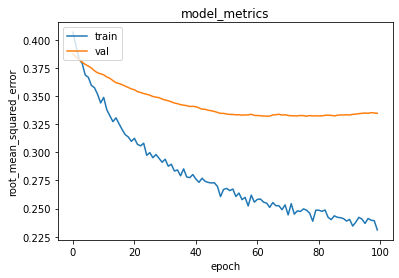

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Proses training model cukup smooth dan model konvergen pada epochs sekitar 100. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.23 dan error pada data validasi sebesar 0.36. Nilai tersebut cukup bagus untuk sistem rekomendasi

## Mendapatkan Rekomendasi Resto

Untuk mendapatkan rekomendasi resto, pertama kita ambil sampel user secara acak dan definisikan variabel resto_not_visited yang merupakan daftar resto yang belum pernah dikunjungi oleh pengguna. Anda mungkin bertanya-tanya, mengapa kita perlu menentukan daftar resto_not_visited? Hal ini karena daftar resto_not_visited inilah yang akan menjadi resto yang kita rekomendasikan. 

Sebelumnya, pengguna telah memberi rating pada beberapa resto yang telah mereka kunjungi. Kita menggunakan rating ini untuk membuat rekomendasi restoran yang mungkin cocok untuk pengguna. Nah, restoran yang akan direkomendasikan tentulah restoran yang belum pernah dikunjungi oleh pengguna. Oleh karena itu, kita perlu membuat variabel resto_not_visited sebagai daftar restoran untuk direkomendasikan pada pengguna. 

Variabel resto_not_visited diperoleh dengan menggunakan operator bitwise (~) pada variabel resto_visited_by_user.



In [ ]:
resto_df = resto_new
df = pd.read_csv('rating_final.csv')
 
# Mengambil sample user
user_id = df.userID.sample(1).iloc[0]
resto_visited_by_user = df[df.userID == user_id]
 
# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html 
resto_not_visited = resto_df[~resto_df['id'].isin(resto_visited_by_user.placeID.values)]['id'] 
resto_not_visited = list(
    set(resto_not_visited)
    .intersection(set(resto_to_resto_encoded.keys()))
)
 
resto_not_visited = [[resto_to_resto_encoded.get(x)] for x in resto_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_resto_array = np.hstack(
    ([[user_encoder]] * len(resto_not_visited), resto_not_visited)
)

Selanjutnya, untuk memperoleh rekomendasi restoran, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [ ]:
ratings = model.predict(user_resto_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_resto_ids = [
    resto_encoded_to_resto.get(resto_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Resto with high ratings from user')
print('----' * 8)
 
top_resto_user = (
    resto_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .placeID.values
)
 
resto_df_rows = resto_df[resto_df['id'].isin(top_resto_user)]
for row in resto_df_rows.itertuples():
    print(row.resto_name, ':', row.cuisine)
 
print('----' * 8)
print('Top 10 resto recommendation')
print('----' * 8)
 
recommended_resto = resto_df[resto_df['id'].isin(recommended_resto_ids)]
for row in recommended_resto.itertuples():
    print(row.resto_name, ':', row.cuisine)

Showing recommendations for users: U1089
Resto with high ratings from user
--------------------------------
crudalia : Bar
VIPS : American
La Virreina : Mexican
Restaurante Tiberius : Pizzeria
--------------------------------
Top 10 resto recommendation
--------------------------------
Gordas de morales : Mexican
La Estrella de Dimas : Mexican
Mariscos Tia Licha : Family
El cotorreo : Mexican
KFC : American
cafe punta del cielo : Cafeteria
emilianos : Bar_Pub_Brewery
Log Yin : Burgers
Restaurant Las Mananitas : International
Michiko Restaurant Japones : Japanese
